# General Instructions

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

* Do NOT import any other modules
* Do NOT change the prototypes of any of the functions
* Sample test cases are already given, test your code using these sample cases
* Grading will be based on hidden test cases
* Please solve this notebook using Google Colab as the required packages are already installed
* To speed up the training, make sure to run the notebook with a GPU support. In the menu bar, select `Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator` type to `GPU`

Make sure you fill in any place that says `YOUR CODE STARTS HERE` or "YOUR ANSWER HERE", as well as your name and ID number below:

In [1]:
NAME = "OMKAR R DURGADA"
ID = "2020A3PS0460P"

## Introduction

In Part 2 of this assignment, we covered forward pass of Convolutional Neural Networks from scratch. In this part, we will build an end-to-end deep neural  network using Pytorch. PyTorch is an open source python library developed by Meta's AI research group designed to provide good flexibility and high speeds for deep neural network implementation.


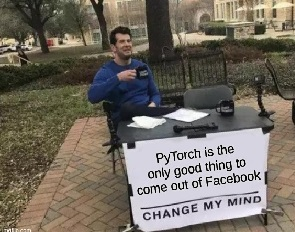



So far, we have an idea of what CNNs are and how they work. Now, we will use a combination of CNNs, activation functions, pooling layers, and fully connected networks to build an image classification model. The figure below shows a complete flow of how a Deep CNN model processes an input image and classifies an image based on the features extracted. 


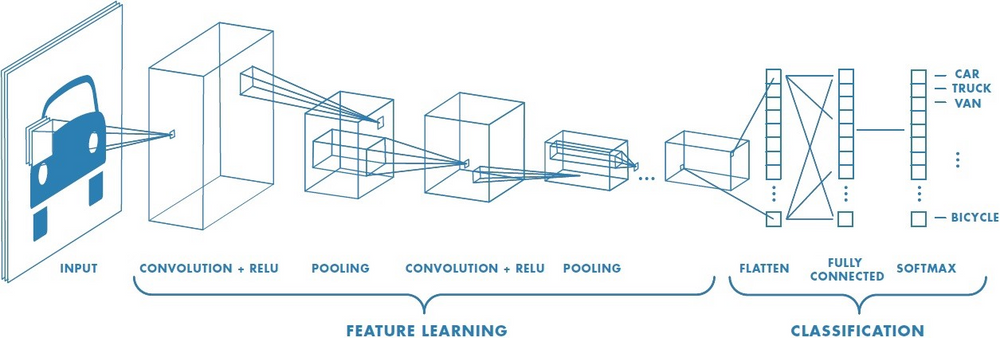

In [2]:
### DO NOT CHANGE THIS CELL ###
# NOTE: DO NOT IMPORT ANY OTHER LIBRARIES

# pytorch related imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


# Other imports
import os
import shutil
import cv2
import numpy as np
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

In [3]:
# Set whether to run the training on GPU or CPU based on availibility of GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# set seed
torch.manual_seed(0)

## About the dataset 

In this part of the assignment we would use the dataset:Caltech-101. 

Caltech-101 consists of pictures of objects belonging to 101 classes. Each image is labelled with a single object. Each class contains roughly 40 to 800 images, totalling around 9k images. Images are of variable sizes, with typical edge lengths of 200-300 pixels. This version contains image-level labels only. However, the original dataset also contains bounding boxes.

<div>
<img src="https://storage.googleapis.com/tfds-data/visualization/fig/caltech101-3.0.1.png" width="500"/>
</div>

## Dataset preparation for training - the `torch.utils.data.Dataset` Class 

In [4]:
### DO NOT CHANGE THIS CELL ###
# Defining relevant variables
batch_size = 64
num_classes = 101

## Data Transforms (EVALUATIVE)

Read: why do we perform data transformation?
Refer to the "Transformation technique overview" section for a more detailed overview of transforms in Pytorch, refer: [this link](https://pytorch.org/vision/stable/transforms.html)


### TODO: [EVALUATIVE: 2MKS]

1. Use [transforms.Resize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize) to resize all the input images and set their size to (224,224).
2. Use [transforms.ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor) to convert all the input images to tensor.
3. Use [transforms.Compose](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose) to merge the three transforms - resize, ToTensor and normalize together.








In [5]:
trans_resize = transforms.Resize((224,224))                             ### YOUR ANSWER HERE
trans_totensor = transforms.ToTensor()    ### YOUR ANSWER HERE
trans_normalize = transforms.Normalize(mean=[0.5],std=[0.5])    ### DO NOT CHANGE THIS

img_transforms =  transforms.Compose([
    trans_resize,
    trans_totensor,
    trans_normalize
])                         ### YOUR ANSWER HERE

## Build train/test dataset (EVALUATIVE)

- Use [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html) to download Caltech101.
- Set transform = img_transforms (from above cell) for both train and test dataset.
- Use 70% for the train dataset and 30% for the test dataset.

In [6]:
# Download and create dataset
dataset = torchvision.datasets.Caltech101('.', transform = img_transforms, download=True)

# Create Training and Testing splits
### YOUR CODE HERE ###
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

### ENDS HERE ###

0it [00:00, ?it/s]

Extracting ./caltech101/101_ObjectCategories.tar.gz to ./caltech101


0it [00:00, ?it/s]

Extracting ./caltech101/Annotations.tar to ./caltech101


In [7]:
# Sample test case 
assert len(train_dataset),len(test_dataset) in [(6073,2604),(6074,2603)] 
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


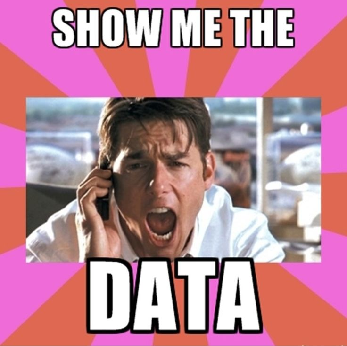

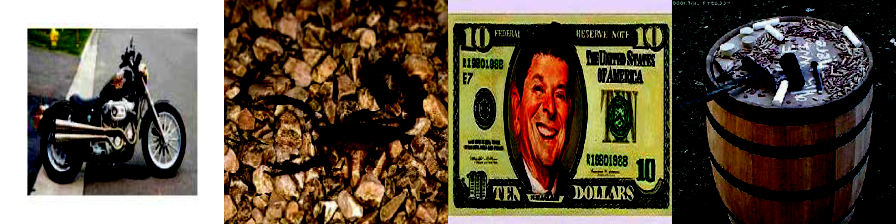

Label class: 3			Label class: 81			Label class: 32			Label class: 8


In [8]:
### DO NOT CHANGE THIS CELL ###

# Lets visualize a few images from the dataset
idxes = torch.randint(0, len(train_dataset), (4,))
imgs,labels = [], []
for idx in idxes:
    imgs.append(cv2.cvtColor((255*train_dataset[idx][0]).permute(1,2,0).numpy(),cv2.COLOR_BGR2RGB))
    labels.append(f"Label class: {train_dataset[idx][1]}")

cv2_imshow(np.concatenate(imgs, axis=1))
print("\t\t\t".join(labels))

In [9]:
### DO NOT CHANGE THIS CELL ###
# Define a set of operations to be performed 
def collate_fn(data):
    # Since the Caltech101 dataset contains both RGB as well as grayscale images, we convert the grayscale images to RGB 
    for i in range(len(data)):
        if data[i][0].shape[0]==1:  # check if the image is 1 channel image i.e. grayscale  
            data[i] = (data[i][0].expand(3,-1,-1),data[i][1])   # expand the images to have RGB channels
    return torch.stack([i[0] for i in data]),torch.tensor([i[1] for i in data])

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2, collate_fn=collate_fn) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers = 2, collate_fn=collate_fn) 

## InceptionNet Model

As part of this assignment, we build the InceptionNet model from scratch. InceptionNet(introduced as GoogLeNet) was initially proposed in 2014 by Google. 

We recommend to go through the [paper](https://arxiv.org/pdf/1409.4842.pdf) before starting this section of the paper. 

Video reference: https://www.youtube.com/watch?v=KfV8CJh7hE0 (By Andrew Ng)

Notet that for the sake of this assignment you can skip the auxiliary classifiers part. 

### Basic building block of InceptionNet - Inception module


### The Naive Inception module
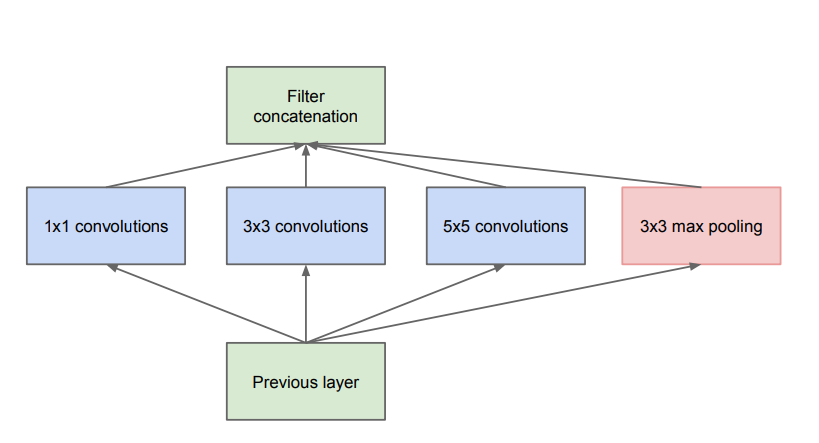

In Pytorch, the `nn.Module` class is base class for all neural network modules. We start building our `NaiveInceptionBlock` and `EfficientInceptionBlock` by creating a class that inherits the `nn.Module` class. The `nn.Module` can also contain other `nn.Module` modules and assign the submodules as attributes too. 

There are two methods of this class which are of particular interest to us:
and then we define the layers and their sequence of execution inside `__init__` 

1. `__init__()` : Consists of the definition of the consituent layers of the Block/Model
2. `forward()` :  Defines the computation to be performed on the inputs using the layers and other blocks defined in `__init__()`.



Following links might be helpful for reading up about the Pytorch layers. 

*   [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
*   [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
*   [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
*   [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
*   [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)


### TODO [EVALUATIVE: 3 MKS]

* In the `__init__()` method, define the required layers as shown in above diagram.
* In the `forward()` method, return the output after performing the required computations. 


Follow the steps shown in the diagram below to build NaiveInceptionBlock & EfficientInceptionBlock:

1. Make use of the `get_conv_batchnorm_relu_block()` function (and pissibly more) to define the convolution blocks inside the `__init__()` methods of `NaiveInceptionBlock` and `EfficientInceptionBlock`.
2. Complete the `forward()` methods using these defined blocks.

In [10]:
# Returns a nn.Sequential model which applies the 2D convolution, BatchNorm and ReLU in order
from collections import OrderedDict

def get_conv_batchnorm_relu_block(in_channels, out_channels, kernel_size,stride=(1, 1),padding=(0,0)):
    ### YOUR CODE HERE
    conv = nn.Conv2d(in_channels, out_channels, kernel_size,stride,padding)
    norm = nn.BatchNorm2d(out_channels)
    relu = nn.ReLU()
    conv_block = nn.Sequential(OrderedDict([
        ('conv', conv),
        ('norm', norm),
        ('relu', relu)
    ]))


    ### YOUR CODE ENDS HERE

    return conv_block

In [11]:
class NaiveInceptionBlock(nn.Module):

    def __init__(self, in_channels, channels_1x1, channels_3x3, channels_5x5):
        super().__init__()
        
        # conv1 (the leftmost branch) 
        self.conv1 = get_conv_batchnorm_relu_block(in_channels, channels_1x1, 1) ### YOUR ANSWER HERE 
        
        # conv2 (the 2nd branch from the left) 
        self.conv2 = get_conv_batchnorm_relu_block(in_channels, channels_3x3, 3, padding=1)                       ### YOUR ANSWER HERE 

        # conv3 (the 3rd branch from the left) 
        self.conv3 = get_conv_batchnorm_relu_block(in_channels, channels_5x5, 5, padding=2)                      ### YOUR ANSWER HERE 
        
        # max1 (the right most branch) 
        self.max1 = nn.MaxPool2d(kernel_size=(3,3))

    def forward(self, x):
        # pass the input through the leftmost branch
        out1 = self.conv1(x)                             ### YOUR ANSWER HERE           

        # pass the input through the 2nd branch
        out2 = self.conv2(x)                            ### YOUR ANSWER HERE 
        
        # pass the input through the 3rd branch
        out3 = self.conv3(x)                             ### YOUR ANSWER HERE 
        
        # pass the input through the rightmost branch
        out4 = self.max1(x)                             ### YOUR ANSWER HERE 

        # concatenate the outputs of indivisual branches
        block_output = torch.cat([out1,out2,out3,out4],1)

        return block_output



### The compute efficient Inception module

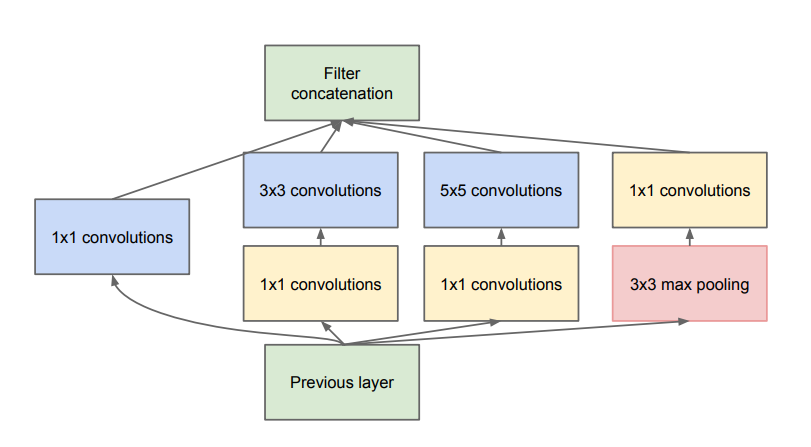

In [12]:
class EfficientInceptionBlock(nn.Module):

    def __init__(self, in_channels, channels_1x1, channels_3x3_reduce, channels_3x3, channels_5x5_reduce, channels_5x5, channels_pool ):
        super().__init__()
        
        # conv1 (the leftmost branch) 
        self.conv1 = get_conv_batchnorm_relu_block(in_channels, channels_1x1, 1)                       ### YOUR ANSWER HERE 
        
        # conv2 (the 2nd branch from the left) 
        self.conv2_1 = get_conv_batchnorm_relu_block(in_channels, channels_3x3_reduce, 1)                      ### YOUR ANSWER HERE 
        self.conv2_2 = get_conv_batchnorm_relu_block(in_channels=channels_3x3_reduce, out_channels=channels_3x3, kernel_size=3, padding=1) ### YOUR ANSWER HERE 

        # conv3 (the 3rd branch from the left) 
        self.conv3_1 = get_conv_batchnorm_relu_block(in_channels=in_channels, out_channels=channels_5x5_reduce, kernel_size=(1,1)) 
        self.conv3_2 = get_conv_batchnorm_relu_block(in_channels=channels_5x5_reduce, out_channels=channels_5x5, kernel_size=(5,5), padding=2) 
        
        # max1 (the rightmost branch) 
        self.max1 = nn.MaxPool2d(kernel_size=3, stride = 1, padding=1)  ### YOUR ANSWER HERE 
        self.conv4 = get_conv_batchnorm_relu_block(in_channels=in_channels, out_channels=channels_pool, kernel_size=1)                         ### YOUR ANSWER HERE 

    def forward(self, x):

        # pass the input through the leftmost branch
        out1 = self.conv1(x)

        # pass the input through the 2nd branch
        out2 = self.conv2_2(self.conv2_1(x))
        
        # pass the input through the 3rd branch
        out3 = self.conv3_2(self.conv3_1(x))
        
        # pass the input through the rightmost branch
        out4 = self.conv4(self.max1(x))

        # concatenate the outputs of indivisual branches
        block_output = torch.cat([out1,out2,out3,out4],1)                      ### YOUR ANSWER HERE 

        return block_output

In [13]:
# Sample test case 
torch.manual_seed(0)
block = EfficientInceptionBlock(3, 64,64,64,64,64,64 )
x1 = torch.randn((1, 3, 224, 224))
y1 = block(x1)
# print(y1.shape)
assert y1.shape[0] == x1.shape[0] 
assert y1.shape[1] == 4*64
assert  y1.shape[2:] == x1.shape[2:]
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


## Complete Architecture of InceptionNet 

The overall architecture is: 

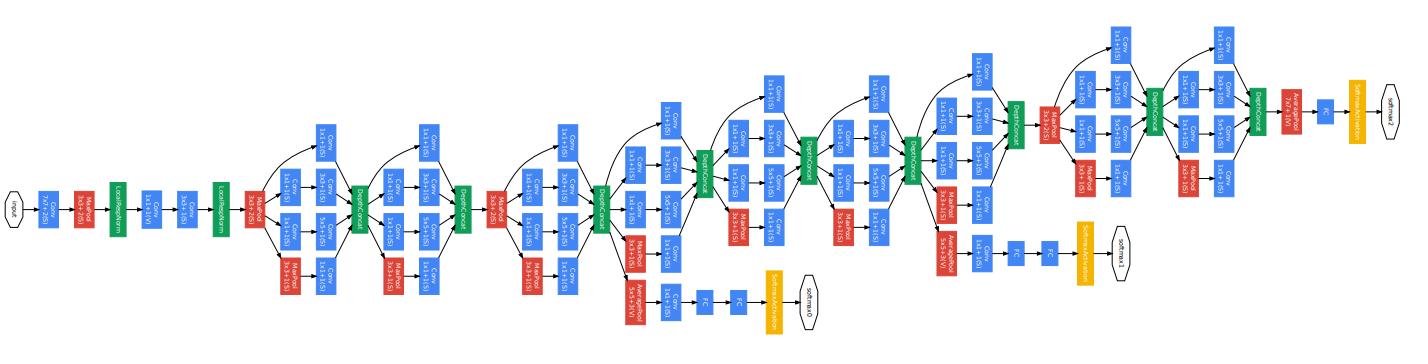

(Please refer the diagram in the paper directly for a more clear image)

#### Note that you do not have to worry about the Auxiliary branches for this assignment.

The detailed architecture design of InceptionNet is:

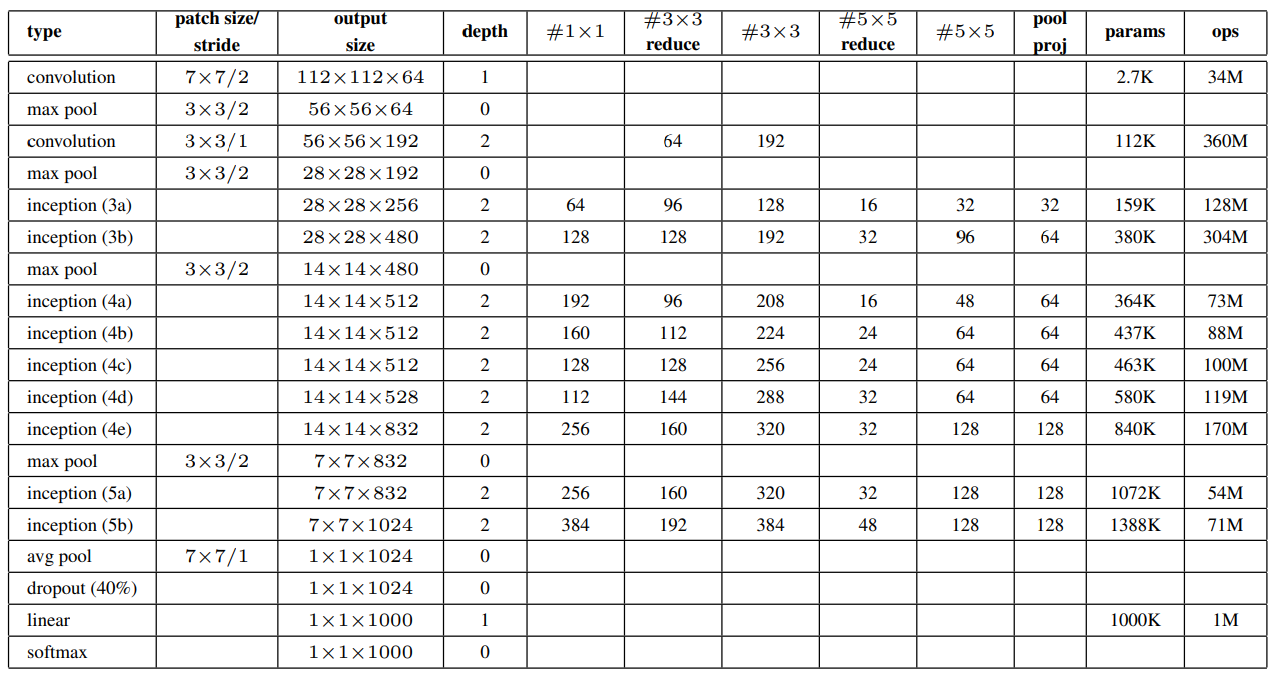

### TODO:[EVALUATIVE: 4MKS]
Refer to the above diagram for completing the code below for InceptionNet module. Take special care for the number of channels input and output at each layer. 



In [14]:
class InceptionNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.conv1 = get_conv_batchnorm_relu_block(
            in_channels=3, 
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # YOUR CODE HERE
        self.conv2 = get_conv_batchnorm_relu_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.inception_3a = EfficientInceptionBlock(192, 64, 96, 128, 16, 32, 32)                    ### YOUR ANSWER HERE 
        self.inception_3b = EfficientInceptionBlock(256, 128, 128, 192, 32, 96, 64)                     ### YOUR ANSWER HERE 
        self.inception_4a = EfficientInceptionBlock(480, 192, 96, 208, 16, 48, 64)
                    ### YOUR ANSWER HERE 
        self.inception_4b = EfficientInceptionBlock(512, 160, 112, 224, 24, 64, 64)                   ### YOUR ANSWER HERE 
        self.inception_4c = EfficientInceptionBlock(512, 128, 128, 256, 24, 64, 64)                    ### YOUR ANSWER HERE 
        self.inception_4d = EfficientInceptionBlock(512, 112, 144, 288, 32, 64, 64)                    ### YOUR ANSWER HERE 
        self.inception_4e = EfficientInceptionBlock(528, 256, 160, 320, 32, 128, 128)                    ### YOUR ANSWER HERE 
        self.inception_5a = EfficientInceptionBlock(832, 256, 160, 320, 32, 128, 128)                    ### YOUR ANSWER HERE 
        self.inception_5b = EfficientInceptionBlock(832, 384, 192, 384, 48, 128, 128)                    ### YOUR ANSWER HERE 

        # dropout 
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        # Note the output logits in this case is from 1024 to number of classes (in our case that is 256)
        self.fc = nn.Linear(1024, self.num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool(x)
        x = self.inception_4a(x)
        
        
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
    
        
        x = self.inception_4e(x)
        x = self.maxpool(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x
        

In [15]:
torch.manual_seed(0)
# Initialize the model and put it on the device
inception_model = InceptionNet(num_classes)
inception_model.to(device)

InceptionNet(
  (conv1): Sequential(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (inception_3a): EfficientInceptionBlock(
    (conv1): Sequential(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2_1): Sequential(
      (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    

## Training utils

In [16]:
### DO NOT CHANGE THIS CELL ###

# training hyper-params
learning_rate = 0.00005
total_epochs = 10

In [17]:
### DO NOT CHANGE THIS CELL ###

# Define the loss and optimizers
# set loss function with criterion
loss_criterion = nn.CrossEntropyLoss()
# Set optimizer with learning rate as stored in the variable above learning_rate
optimizer = torch.optim.Adam(inception_model.parameters(), lr=learning_rate)  

## Train Loop

A typical Pytorch training loop involves the following steps:

1. Perform the forward pass
2. Calculate the loss
3. Perform backpropagation: First to ensure that all the gradients are set to zero and then compute them based on the loss computed 
4. Update the parameters

### TODO: [EVALUATIVE: 1MK] 

Complete the below training loop based on this. You may refer [here](https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html) for inspiration. Note that it may take some time to train the model.

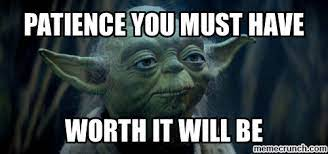

In [18]:
# Put the model into training mode. This activates the dropout and batchnorm layers for training
inception_model.train()

# Driving training loop
for epoch in tqdm(range(1,total_epochs+1)):
        
    total_epoch_loss=0
    # Iterate through train dataset
    for batch_id, (images,labels) in enumerate(train_loader):
        
        # put the images and labels tensors to the device 
        images,labels = images.to(device), labels.to(device)
                
        # 1. forward pass the inputs through the model
        prediction =  inception_model(images)                          ### YOUR ANSWER HERE 

        # 2. compute the loss for this iteration
        loss = loss_criterion(prediction, labels)                                 ### YOUR ANSWER HERE 
        total_epoch_loss += loss.item()

        # 3. zero out the gradients and perform backpropagation through the network
        optimizer.zero_grad()
        loss.backward()

        # 4. update the parameters
        optimizer.step()

    print(f"Epoch: [{epoch}/{total_epochs}] Epoch Loss: {total_epoch_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [1/10] Epoch Loss: 361.3037507534027
Epoch: [2/10] Epoch Loss: 290.2983877658844
Epoch: [3/10] Epoch Loss: 256.32267665863037
Epoch: [4/10] Epoch Loss: 235.63026916980743
Epoch: [5/10] Epoch Loss: 214.7225924730301
Epoch: [6/10] Epoch Loss: 197.05530178546906
Epoch: [7/10] Epoch Loss: 178.13875365257263
Epoch: [8/10] Epoch Loss: 160.52221977710724
Epoch: [9/10] Epoch Loss: 145.15977787971497
Epoch: [10/10] Epoch Loss: 128.58573293685913


## Testing

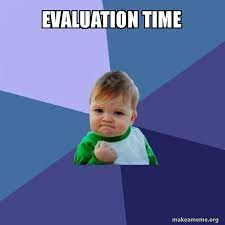

Test your model accuracy on train and test dataset by running the cells below. If everything is correct, your accuracy on the train split will be ~75-80% and  on the test split will be about ~55-60%. Note that these accuracies will get higher if you train the model for more epochs, however, for the sake of convenience, we limit ourselves to the above specified epochs only.

Note that this concept is called overfitting. There are certain ways to deal with it but that is out of scope of this assignment. Although feel free to go through [this article](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/#:~:text=Overfitting%20in%20Machine%20Learning&text=Overfitting%20happens%20when%20a%20model,as%20concepts%20by%20the%20model.) if you're curious about it. 

In [19]:
inception_model.eval()

# Calculate Training Accuracy  
with torch.no_grad():
    correct = 0
    total = 0
    # Iterate through train dataset
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = inception_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of InceptionNet on {len(train_dataset)} train images: {100 * correct / total} %')

Accuracy of InceptionNet on 6073 train images: 76.40375432241068 %


In [20]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of InceptionNet on {len(test_dataset)} test images: {100 * (correct / total)} %')

Accuracy of InceptionNet on 2604 test images: 55.64516129032258 %


*And that's a wrap! Congratulation on building your first Deep Neural Network! Hope you enjoyed the (possibly challenging) assignment!*

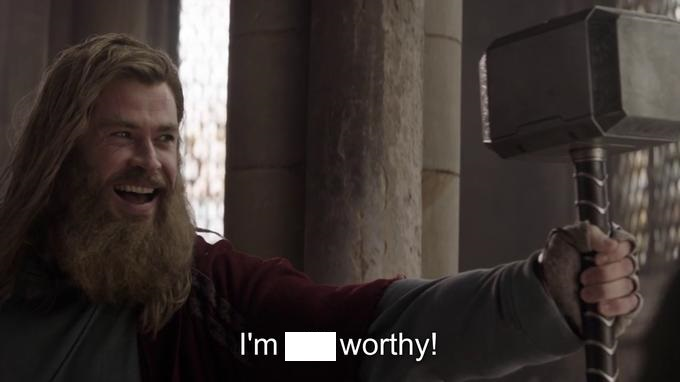

# End of this part
Assignment by: Atharva Chandak (f20190062@pilani.bits-pilani.ac.in), Sarthak Gupta (f20190464@pilani.bits-pilani.ac.in), 

Asish Juttu (f20190039@pilani.bits-pilani.ac.in)

Feel free to reach out to any of the TAs in case of any doubts reguarding the assignment.

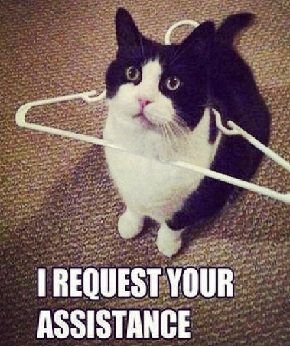